In [3]:
import pandas as pd
import sys
sys.path.insert(0, '../')

# from interface import get_query_emb_batch, load_model, cosine_similarity_batch

from typing import Tuple, List, Dict, Union, Any

from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.modeling.checkpoint import Checkpoint
from colbert.modeling.colbert import colbert_score
from colbert.data import Queries, Collection
from colbert import Indexer, Searcher

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score

import pandas as pd
import numpy as np
import torch
import os


In [4]:
def load_model(ckpt_fld: str, doc_maxlen: int, nbits: int, kmeans_niters: int, device: str) -> Checkpoint:
    """
    Load a ColBERT model from a checkpoint folder and configure it based on provided parameters.

    Args:
        ckpt_fld (str): Path to the checkpoint folder.
        doc_maxlen (int): Maximum length of the document.
        nbits (int): Number of bits for the embedding.
        kmeans_niters (int): Number of iterations of k-means clustering; 4 is a good and fast default.
        device (str): Device to use, either "cuda" or "cpu".

    Returns:
        ColBERT: Loaded ColBERT model configured with the specified parameters.
    """
    config = ColBERTConfig(doc_maxlen=doc_maxlen, nbits=nbits, kmeans_niters=kmeans_niters)
    checkpoint = Checkpoint(ckpt_fld, colbert_config=config)
    return checkpoint.to(device)

def get_query_emb(sentences: List[str], checkpoint: Checkpoint, batch_size: int, is_mean: bool) -> np.ndarray:
    """
    Generate embeddings for a list of sentences using the provided checkpoint.

    Args:
        sentences (List[str]): A list of sentences for which embeddings need to be generated.
        checkpoint (Checkpoint): The checkpoint object used for generating embeddings.
        batch_size (int): The batch size to use during inference.

    Returns:
        np.ndarray: An array of embeddings for the input sentences.
    """
    if is_mean:
        return np.mean(checkpoint.queryFromText(sentences, bsize=batch_size).to("cpu").numpy(), axis=1)
    else:
        return checkpoint.queryFromText(sentences, bsize=batch_size).to("cpu").numpy()
        
def get_query_emb_batch(sentences: List[str], checkpoint: Checkpoint, batch_size: int, batch_size2: int, is_mean: bool=True) -> np.ndarray:
    """
    Generate embeddings for a list of sentences in batches using the provided checkpoint.

    Args:
        sentences (List[str]): A list of sentences for which embeddings need to be generated.
        checkpoint (Checkpoint): The checkpoint object used for generating embeddings.
        batch_size (int): The batch size to use during inference.
        batch_size2 (int): The size of the sub-batches to split the input sentences into.
        mean (bool): Reducing the dimension of embeddings by averaging over all tokens

    Returns:
        np.ndarray: An array of embeddings for the input sentences. 
        Shape of the array is (len(sentences), 768) for bert-base-multilingual-cased or (len(sentences), 128) for colbertv2.0
        if is_mean=False array shapes are (len(sentences), 32, 768) and (len(sentences), 32, 128) 
    """
    embeddings_list = []
    
    for i in range(0, len(sentences), batch_size2):
        # print(f"batch: {min(i+batch_size2, len(sentences))}/{len(sentences)}")

        batch_sentences = sentences[i:i+batch_size2]
        embeddings = get_query_emb(batch_sentences, checkpoint, batch_size, is_mean)
        embeddings_list.append(embeddings)

        torch.cuda.empty_cache()
    return np.concatenate(embeddings_list, axis=0)

In [5]:
def fn(x):
    return x.strip().replace("\n", " ").replace("\t", " ")
    
df_test = pd.read_parquet("/home/sondors.igor/documents/ColBERT/DATASET/pairs_test_names.parquet")

clms = ['name1', 'name2']
for c in clms:
    df_test[c] = df_test[c].apply(fn)
    
df_test

,NmId1,NmId2,subjectid,subjectname,Target,HardNegative,name1,name2
0,7321082,4132696,381,Книги,0,1.0,детская литература Маленький принц серия Билин...,эксмо Маленький принц Вес товара без упаковки ...
1,8811543,929620,98,Сабо,0,1.0,"crocs Сабо Crocband Clog Комплектация: сабо, б...",crocs Сабо резиновые летние Комплектация: сабо...
2,10525931,10525930,4472,Насосы поверхностные,0,0.0,"denzel Насос для воды поверхностный GP1100C, 4...","denzel Насос для воды поверхностный GP1000Х, 3..."
3,10609515,10609382,2915,Семена,0,0.0,семена алтая Семена Цветов Бегония Фортун Пич ...,семена алтая Семена Цветов Бегония Фортун Смес...
4,11755361,10306338,731,Игрушки для животных,0,1.0,doglike Игрушка для собак мяч лайкер с веревко...,"doglike Мяч для собак с канатом Доглайк 8,5см ..."
...,...,...,...,...,...,...,...,...
2562441,222570833,149996012,2501,Воблеры,0,1.0,100ribakoff Набор воблер WALLEY DEEP 27 ft-10 ...,mens world Набор воблер Bandit WALLEY DEEP 27 ...
2562442,222582652,210034640,515,Смартфоны,0,0.0,realme Смартфон C53 8/256Gb Gold Вес товара бе...,realme Смартфон C53 8/256 Гб Комплектация: док...
2562443,223135523,210133897,357,Кремы,0,0.0,ваше хозяйство Активист гель для суставов и мы...,ваше хозяйство Мазь для суставов от боли Актив...
2562444,224321362,212964087,5806,Комплекты клавиатур и мышей,0,0.0,aula Клавиатура с мышкой беспроводная мембранн...,smartbuy Клавиатура и мышка беспроводная компь...


In [6]:
# ckpt_pth = "/home/sondors.igor/documents/ColBERT/experiments/colbertv2_lr04_bs_50_grad_clip_doc_maxlen/none/2024-09/11/14.16.36/checkpoints/colbert-8000-finish"
# ckpt_pth = "/home/sondors.igor/documents/ColBERT/experiments/colbertv2_lr04_bs_50_grad_clip_doc_maxlen/none/2024-09/11/14.16.36/checkpoints/colbert-172000-finish"
ckpt_pth = "/home/sondors.igor/documents/ColBERT/experiments/colbertv2_lr04_bs_50_grad_clip_doc_maxlen/none/2024-09/11/14.16.36/checkpoints/colbert-297010-finish"
doc_maxlen = 300
nbits = 2   # bits определяет количество битов у каждого измерения в семантическом пространстве во время индексации
nranks = 1  # nranks определяет количество GPU для использования, если они доступны
kmeans_niters = 4 # kmeans_niters указывает количество итераций k-means кластеризации; 4 — хороший и быстрый вариант по умолчанию. 

device = "cuda"

checkpoint = load_model(ckpt_pth, doc_maxlen, nbits, kmeans_niters, device)

In [7]:
def process_chunk(chunk_id, df, checkpoint):
    embs_name1 = get_query_emb_batch(list(df['name1']), checkpoint, batch_size=1000, batch_size2=10000)
    embs_name2 = get_query_emb_batch(list(df['name2']), checkpoint, batch_size=1000, batch_size2=10000)
    df['pair_score'] = [cosine_similarity(embs_name1[i].reshape(1, -1), embs_name2[i].reshape(1, -1))[0][0] 
                        for i in range(len(embs_name2))]
    return df

df_chunks = np.array_split(df_test, 20)
input_args = ((chunk_id, df) for chunk_id, df in enumerate(df_chunks))

chunks = []
for chunk_id, df in input_args:
    print(f"chunk_id: {chunk_id}")
    chunks.append(process_chunk(chunk_id, df, checkpoint))

df_test_scores = pd.concat(chunks, axis=0)
df_test_scores

chunk_id: 0
chunk_id: 1
chunk_id: 2
chunk_id: 3
chunk_id: 4
chunk_id: 5
chunk_id: 6
chunk_id: 7
chunk_id: 8
chunk_id: 9
chunk_id: 10
chunk_id: 11
chunk_id: 12
chunk_id: 13
chunk_id: 14
chunk_id: 15
chunk_id: 16
chunk_id: 17
chunk_id: 18
chunk_id: 19


,NmId1,NmId2,subjectid,subjectname,Target,HardNegative,name1,name2,pair_score
0,7321082,4132696,381,Книги,0,1.0,детская литература Маленький принц серия Билин...,эксмо Маленький принц Вес товара без упаковки ...,0.610596
1,8811543,929620,98,Сабо,0,1.0,"crocs Сабо Crocband Clog Комплектация: сабо, б...",crocs Сабо резиновые летние Комплектация: сабо...,0.907887
2,10525931,10525930,4472,Насосы поверхностные,0,0.0,"denzel Насос для воды поверхностный GP1100C, 4...","denzel Насос для воды поверхностный GP1000Х, 3...",0.784729
3,10609515,10609382,2915,Семена,0,0.0,семена алтая Семена Цветов Бегония Фортун Пич ...,семена алтая Семена Цветов Бегония Фортун Смес...,1.000000
4,11755361,10306338,731,Игрушки для животных,0,1.0,doglike Игрушка для собак мяч лайкер с веревко...,"doglike Мяч для собак с канатом Доглайк 8,5см ...",0.842389
...,...,...,...,...,...,...,...,...,...
2562441,222570833,149996012,2501,Воблеры,0,1.0,100ribakoff Набор воблер WALLEY DEEP 27 ft-10 ...,mens world Набор воблер Bandit WALLEY DEEP 27 ...,0.463024
2562442,222582652,210034640,515,Смартфоны,0,0.0,realme Смартфон C53 8/256Gb Gold Вес товара бе...,realme Смартфон C53 8/256 Гб Комплектация: док...,0.859402
2562443,223135523,210133897,357,Кремы,0,0.0,ваше хозяйство Активист гель для суставов и мы...,ваше хозяйство Мазь для суставов от боли Актив...,0.780289
2562444,224321362,212964087,5806,Комплекты клавиатур и мышей,0,0.0,aula Клавиатура с мышкой беспроводная мембранн...,smartbuy Клавиатура и мышка беспроводная компь...,0.353469


In [15]:
index = 2
offer1, offer2 = df_test.iloc[index].name1, df_test.iloc[index].name2
offer1, offer2 

('denzel Насос для воды поверхностный GP1100C, 4500 л/ч, DENZEL 97203 Высота предмета: 29.0 см; Комплектация: Насос; Ширина предмета: 41.0 см',
 'denzel Насос для воды поверхностный GP1000Х, 3500 л/ч, DENZEL 97202 Высота предмета: 26.0 см; Комплектация: Насос; Ширина предмета: 37.0 см')

In [8]:
def calculate_metrics(thresholds, text_cos_sim, true_target):
    """
    text_cos_sim старый энкодер:
    Лучший порог: 0.93
    Accuracy при лучшем пороге: 0.4688
    Precision при лучшем пороге: 0.3667
    Recall при лучшем пороге: 0.8635
    F1 Score при лучшем пороге: 0.5148
    """
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in thresholds:
        predicted_target = (text_cos_sim > threshold).astype(int)
        
        accuracy = accuracy_score(true_target, predicted_target)
        precision = precision_score(true_target, predicted_target, zero_division=1)
        recall = recall_score(true_target, predicted_target, zero_division=1)
        f1 = f1_score(true_target, predicted_target, zero_division=1)
        
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]
    
    print(f"Лучший порог: {best_threshold:.2f}")
    print(f"Accuracy при лучшем пороге: {accuracies[best_index]:.4f}")
    print(f"Precision при лучшем пороге: {precisions[best_index]:.4f}")
    print(f"Recall при лучшем пороге: {recalls[best_index]:.4f}")
    print(f"F1 Score при лучшем пороге: {f1_scores[best_index]:.4f}")


text_cos_sim = df_test_scores['pair_score']
true_target = df_test_scores['Target']
thresholds = np.arange(0.0, 1.01, 0.1)  # от 0 до 1 с шагом 0.01

print(f"text_cos_sim:")
calculate_metrics(thresholds, text_cos_sim, true_target)

text_cos_sim:
Лучший порог: 0.70
Accuracy при лучшем пороге: 0.5692
Precision при лучшем пороге: 0.4172
Recall при лучшем пороге: 0.8068
F1 Score при лучшем пороге: 0.5500


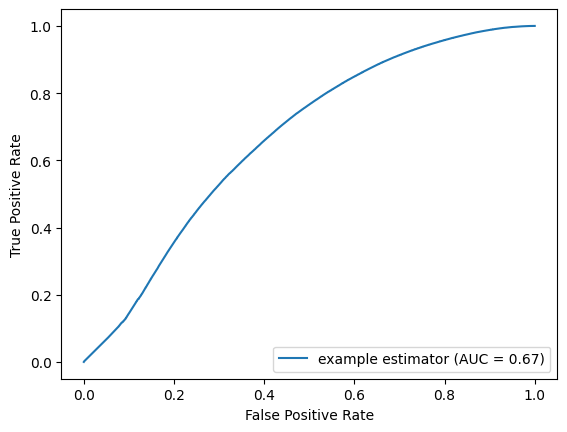

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
pred = np.array(list(df_test_scores['pair_score']))
y = np.array(list(df_test_scores['Target']))
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

In [ ]:
colbert-172000-finish

auc = 0.65

text_cos_sim:
Лучший порог: 0.70
Accuracy при лучшем пороге: 0.5082
Precision при лучшем пороге: 0.3888
Recall при лучшем пороге: 0.8871
F1 Score при лучшем пороге: 0.5407


colbert-52000-finish

text_cos_sim:
Лучший порог: 0.70
Accuracy при лучшем пороге: 0.4812
Precision при лучшем пороге: 0.3773
Recall при лучшем пороге: 0.8885
F1 Score при лучшем пороге: 0.5296

colbert-х-finish
text_cos_sim:
Лучший порог: 0.70
Accuracy при лучшем пороге: 0.4704
Precision при лучшем пороге: 0.3744
Recall при лучшем пороге: 0.9111
F1 Score при лучшем пороге: 0.5308

In [10]:
def get_preds(df, threshold):
    df.loc[df['pair_score'] >= threshold, 'predict'] = 1
    df.loc[df['pair_score'] < threshold, 'predict'] = 0
    return list(df['predict'].astype(int))

thresholds = [i/10 for i in range(10)]

for threshold in thresholds:
    print(f"threshold = {threshold}")
    all_labels = df_test_scores['Target']
    all_preds = get_preds(df_test_scores, threshold)
    
    report = classification_report(all_labels, all_preds, digits=3)
    auc = float(roc_auc_score(all_labels, all_preds))
    
    print(report)
    print(f"auc = {auc}\n")

threshold = 0.0
              precision    recall  f1-score   support

           0      1.000     0.001     0.003     67124
           1      0.329     1.000     0.495     32876

    accuracy                          0.330    100000
   macro avg      0.665     0.501     0.249    100000
weighted avg      0.779     0.330     0.165    100000

auc = 0.5006778499493475

threshold = 0.1
              precision    recall  f1-score   support

           0      0.995     0.003     0.007     67124
           1      0.329     1.000     0.496     32876

    accuracy                          0.331    100000
   macro avg      0.662     0.502     0.251    100000
weighted avg      0.777     0.331     0.167    100000

auc = 0.5016161005559049

threshold = 0.2
              precision    recall  f1-score   support

           0      0.995     0.009     0.018     67124
           1      0.331     1.000     0.497     32876

    accuracy                          0.335    100000
   macro avg      0.663     

In [28]:
2 * 0.88 * 0.90 / (0.88 + 0.90)

0.8898876404494382